# Text classification (sentiment analysis)
Task: Predict sentiment of Amazon reviews
Dataset: Beans from TFDS

## 1. Loading dataset & basic preprocessing
- removal of reviews shorter than 5 characters
- mapping from 1-5 -> 0,1,2
- subsampling - without replacement, random state 42, 80 000 rows

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from IPython.display import display
import re
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
import datetime
from keras_tuner import HyperModel, RandomSearch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2024-05-20 09:13:43.826634: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 09:13:43.826687: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 09:13:43.867354: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-20 09:13:43.950213: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-20 09:13:44.934489: W tensorflow/compiler/tf2

In [2]:
tf.__version__

'2.15.0'

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-05-20 09:13:46.123693: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-20 09:13:46.259826: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-20 09:13:46.259890: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
df = pd.read_csv('datasets/amazon_reviews_us_Major_Appliances_v1_00.tsv', sep='\t', on_bad_lines='skip')

In [5]:
df.shape

(96834, 15)

In [6]:
# remove nas and duplicate reviews
df.dropna(axis=0, subset=['review_body'], inplace=True)
df.drop_duplicates(subset=['review_body'], inplace=True)

In [7]:
df.shape

(93446, 15)

In [8]:
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to /home/balv05/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def remove_tags(review):
    return re.sub(pattern='<.*?>', string=review , repl=' ') 

def keep_alnum(review):
    return re.sub(pattern='[^A-Za-z\d\s:]', string=review, repl=' ')

def strip_spaces(review):
    return re.sub(pattern='[\s]{2,}', string=review, repl=' ')

def lowercase(review):
    return review.lower()

def remove_stopwords(review):
    review_list = review.split()
    return " ".join([word for word in review_list if word not in stopword_list])

In [10]:
df['review_body'] = df['review_body'].apply(remove_tags)        # remove html tags
df['review_body'] = df['review_body'].apply(keep_alnum)         # remove sub unicode char
df['review_body'] = df['review_body'].apply(strip_spaces)       # strip all unnecessary whitespaces
df['review_body'] = df['review_body'].apply(lowercase)          # put everything into lowercase
df['review_body'] = df['review_body'].apply(remove_stopwords)   # put everything into lowercase
df = df[df['review_body'].str.len() > 5]                        # keep only reviews longer than 5 characters

In [11]:
df

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,16199106,R203HPW78Z7N4K,B0067WNSZY,633038551,"FGGF3032MW Gallery Series 30"" Wide Freestandin...",Major Appliances,5,0,0,N,Y,"If you need a new stove, this is a winner.",great stove wonderful replacement sort antique...,2015-08-31
1,US,16374060,R2EAIGVLEALSP3,B002QSXK60,811766671,Best Hand Clothes Wringer,Major Appliances,5,1,1,N,Y,Five Stars,worked great,2015-08-31
2,US,15322085,R1K1CD73HHLILA,B00EC452R6,345562728,Supco SET184 Thermal Cutoff Kit,Major Appliances,5,0,0,N,Y,Fast Shipping,part exactly needed saved purchasing,2015-08-31
3,US,32004835,R2KZBMOFRMYOPO,B00MVVIF2G,563052763,Midea WHS-160RB1 Compact Single Reversible Doo...,Major Appliances,5,1,1,N,Y,Five Stars,love refrigerator keeps everything cold recommend,2015-08-31
4,US,25414497,R6BIZOZY6UD01,B00IY7BNUW,874236579,Avalon Bay Portable Ice Maker,Major Appliances,5,0,0,N,Y,Five Stars,running store ice works perfectly,2015-08-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96829,US,37431087,R3CYIDM3UEY5PA,B00005O64S,222987122,Haier HDT18PA Space Saver Compact Countertop D...,Major Appliances,4,37,43,N,N,Pretty good dishwasher for small apartment,pretty good dishwasher price good job cleaning...,2002-07-14
96830,US,44686434,R1PLFLGSA6N9WU,B00005O64T,802734810,Haier America HSE02-WNAWW 1.8-Cubic-Foot Capac...,Major Appliances,1,33,39,N,N,Does not last long,bought office extremely dissatisfied stopped w...,2002-06-03
96831,US,36739731,RBPARLMOY6ZU5,B00005O64S,222987122,Haier HDT18PA Space Saver Compact Countertop D...,Major Appliances,5,6,45,N,N,Rave review for space saver,saw small dishwasher thought wonderful idea sm...,2002-05-05
96832,US,50744080,RSS5TDZOGUEB6,B00004SACT,344802997,Sanyo Two-Door 2.9 Cubic Foot Refrigerator,Major Appliances,4,71,71,N,N,Sanyo compact refrigerator,probably best small refrigerator market true f...,2000-09-29


In [12]:
df.loc[df['star_rating'] < 3, 'sentiment'] = 0
df.loc[df['star_rating'] == 3, 'sentiment'] = 1
df.loc[df['star_rating'] > 3, 'sentiment'] = 2
df['sentiment'] = df['sentiment'].astype('int')
df.drop('star_rating', axis=1, inplace=True)
df = resample(df, n_samples=80000, random_state=42, replace=False)

In [13]:
df

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment
71963,US,23022807,R3IZQ5QBR0C7B7,B0039V7JFG,184993957,LG 3.6 CF FRONT LOAD WASHER DRYER COMBO,Major Appliances,5,14,N,N,lg small washer/dryer set,usually rate things hate exactly feel small lg...,2013-04-06,0
15508,US,21831333,R2LGGHUB944XMT,B00EJPHJVK,516641616,Fantech Lint Trap for Dryer Booster - DBLT4W (...,Major Appliances,0,0,N,Y,very hard to open must be securely mounted no ...,hard open must securely mounted provisions,2015-04-16,1
3110,US,11941986,R21U3YZPS3MBXG,B00HH2YZT6,73366442,Samsung RF32FMQDBSR 4-Door Refrigerator with C...,Major Appliances,6,6,N,N,15 month useful life - this should be disconti...,15 months stopped working threw groceries call...,2015-08-07,0
88804,US,46476694,R2JZ0YSJ5QEZX4,B001VKY8GU,232040651,Koolatron Coca Cola Personal Cube Fridge,Major Appliances,0,0,N,N,Unexpectedly Awesome,silver version tiny cooler fridge company chri...,2011-06-28,2
18295,US,48338607,R2QENB1J5LBM14,B00MZH0OPC,394118467,( 2 PACK ) 3392519 - DRYER THERMAL FUSE for Wh...,Major Appliances,0,0,N,Y,Perfect,exactly needed get dryer back,2015-03-22,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62973,US,31634986,R173X6QPB1N8SY,B004HXDLJ8,693470227,Whynter BWR-18SD 18 Bottle Built-In Wine Refri...,Major Appliances,11,12,N,Y,Very Happy,purchased replace space 12 34 garbage compacto...,2013-09-28,2
45682,US,52949439,R4YB9KY26NLPP,B003GFAY52,647457047,Broan 30W in. QP2 Under Cabinet Range Hood,Major Appliances,9,9,N,Y,Up until it quit working I though I had made a...,bought item professionally installed middle ap...,2014-07-07,0
84940,US,42829199,R1W9QEUT7MIYGD,B004WP4BAO,480751909,Samsung DV5451AGW,Major Appliances,4,4,N,N,Does NOT dry clothes. So not much of a dryer.,purchased nice looking supposedly good name br...,2012-02-18,0
1873,US,19293947,R12LFU2ZVPAZSS,B0125S2K0M,504103070,Avalon Top Loading Water Cooler Dispenser - Ho...,Major Appliances,144,156,N,N,Avalon water dispenser beat my many previous w...,videoid:8829556f67d2453e377e6459465db27e first...,2015-08-16,2


## 2. Final dataset
- 80 000 instances
- NEGATIVE 21 334
- NEUTRAL 5 674
- POSITIVE 52 992 
- **Quite imbalanced -> experiment with class weights**
- 90:10 train:test split

In [14]:
df['sentiment'].value_counts()

sentiment
2    52992
0    21334
1     5674
Name: count, dtype: int64

In [15]:
# Train-test split
df_multimodal = df
df = df[['review_body', 'sentiment']]

X_train, X_test, y_train, y_test = train_test_split(
    df['review_body'], df['sentiment'], random_state=42, test_size=0.1, stratify=df['sentiment']
)
#Train-val split
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)


In [16]:
y_train.value_counts()

sentiment
2    42924
0    17280
1     4596
Name: count, dtype: int64

In [17]:
y_test.value_counts()

sentiment
2    5299
0    2134
1     567
Name: count, dtype: int64

### 3. Recurrent Neural Network

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

2024-05-20 09:13:54.427989: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-20 09:13:54.428072: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-20 09:13:54.428110: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-20 09:13:54.589302: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-20 09:13:54.589387: I external/local_xla/xla/stream_executor

In [17]:
max_length = 100
max_tokens = 8000

text_vectorization = TextVectorization(
    ngrams=1,
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length
)

text_only_train_ds = train_dataset.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

In [20]:
vocab = np.array(text_vectorization.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'one', 'water', 'would', 'great', 'like', 'get',
       'unit', 'ice', 'time', 'use', 'machine', 'well', 'good', 'washer',
       'product', 'works', 'new', '2'], dtype='<U15')

In [18]:
# Define a function to vectorize the texts
def vectorize_text(text, label):
    return text_vectorization(text), label

# Apply the vectorization to the training, validation, and test datasets
train_ds = (train_dataset.map(vectorize_text).cache()
            .shuffle(10000)
            .batch(32)
            .prefetch(buffer_size=tf.data.AUTOTUNE))

val_ds = (validation_dataset.map(vectorize_text)
          .cache()
          .batch(32)
          .prefetch(buffer_size=tf.data.AUTOTUNE))

test_ds = (test_dataset.map(vectorize_text)
           .cache()
           .batch(32)
           .prefetch(buffer_size=tf.data.AUTOTUNE))


In [19]:
for inputs, targets in train_ds:
    print("inputs data type",inputs.dtype)
    print("inputs shape",inputs.shape)
    print("targets data type",targets.dtype)
    print("targets shape",targets.shape)
    print("inputs[0]", inputs)
    #print(inputs[0].numpy().decode('utf-8'))
    print("targets[0]", targets)
    break

inputs data type <dtype: 'int64'>
inputs shape (32, 100)
targets data type <dtype: 'int64'>
targets shape (32,)
inputs[0] tf.Tensor(
[[ 738  805  500 ...  152    1   28]
 [2365   32  193 ...    0    0    0]
 [6081    1  331 ...    0    0    0]
 ...
 [  55    9  151 ...    0    0    0]
 [1024  659 3231 ...    0    0    0]
 [  27  170  738 ...    0    0    0]], shape=(32, 100), dtype=int64)
targets[0] tf.Tensor([2 2 2 2 2 2 2 2 2 0 0 2 1 2 0 0 2 2 1 2 2 0 2 2 2 1 2 2 0 2 0 0], shape=(32,), dtype=int64)


2024-05-20 09:17:37.841925: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [20]:
negative, neutral, positive = np.bincount(df['sentiment'])

In [21]:
negative, neutral, positive

(21334, 5674, 52992)

In [22]:
### proportional calculation of weights 

weight_for_0 = (1 / negative) * (df.shape[0] / 3)
weight_for_1 = (1 / neutral) * (df.shape[0] / 3)
weight_for_2 = (1 / positive) * (df.shape[0] / 3)
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))

Weight for class 0: 1.25
Weight for class 1: 4.70
Weight for class 2: 0.50


In [23]:
def get_conf_matrix(model):
    predictions = model.predict(test_ds)
    classes = tf.argmax(predictions, axis=-1)
    intensity = confusion_matrix(y_test, list(classes.numpy()))
    disp = ConfusionMatrixDisplay(confusion_matrix = intensity, display_labels=[0,1,2])
    disp.plot()

In [24]:
def create_RNN(max_length, embedding_dim = 128, lstm_units = 16, optimizer = 'sgd', metrics = 'accuracy'):
    inputs = keras.Input(shape=(max_length,), dtype="int64")

    x = layers.Embedding(max_tokens, embedding_dim)(inputs)

    # Bidirectional LSTM layer
    x = layers.Bidirectional(layers.LSTM(lstm_units))(x)

    # Output layer for binary classification
    outputs = layers.Dense(3, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)
    
    # Compile the model
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[metrics])

    return model

def create_CNN(max_length, embedding_dim = 128, dropout_rate = 0.5, optimizer = 'sgd', metrics = 'accuracy', activation = 'relu'):

    inputs = keras.Input(shape=(max_length,), dtype="int64")

    x = layers.Embedding(max_tokens, embedding_dim, input_length=max_length)(inputs)
    x = layers.Conv1D(filters = 128, kernel_size =  5, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=64, kernel_size=4, padding='same', activation=activation)(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=32, kernel_size=4, padding='same', activation=activation)(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=32, kernel_size=4, padding='same', activation=activation)(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dense(10, activation = 'sigmoid')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = keras.layers.Flatten()(x)

    outputs = layers.Dense(3, activation = 'sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[metrics])

    return model


## 3. Train Reccurent Neural Network
- train baseline model with basic parameters
- train baseline model with basic parameters + adjusted weights
- implement hyperparameter tuning using TFDF 

### 3.1 RNN with default weights and default hyperparameters

2024-05-19 20:22:55.110693: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 128)          1024000   
                                                                 
 bidirectional (Bidirection  (None, 32)                18560     
 al)                                                             
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 1042659 (3.98 MB)
Trainable params: 1042659 (3.98 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20


2024-05-19 20:22:58.298016: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-05-19 20:22:58.373692: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f03e9ad73e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-19 20:22:58.373726: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
I0000 00:00:1716142978.399132  410299 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2025/2025 [==============================] - 54s 25ms/step - loss: 0.8086 - accuracy: 0.6624 - val_loss: 0.7901 - val_accuracy: 0.6624
Epoch 2/20
2025/2025 [==============================] - 39s 19ms/step - loss: 0.7620 - accuracy: 0.6627 - val_loss: 0.7359 - val_accuracy: 0.6821
Epoch 3/20
2025/2025 [==============================] - 41s 20ms/step - loss: 0.6886 - accuracy: 0.7297 - val_loss: 0.6119 - val_accuracy: 0.7711
Epoch 4/20
2025/2025 [==============================] - 39s 19ms/step - loss: 0.5784 - accuracy: 0.7899 - val_loss: 0.6455 - val_accuracy: 0.7500
Epoch 5/20
2025/2025 [==============================] - 38s 19ms/step - loss: 0.5204 - accuracy: 0.8169 - val_loss: 0.5817 - val_accuracy: 0.7808
Epoch 6/20
2025/2025 [==============================] - 39s 19ms/step - loss: 0.4868 - accuracy: 0.8309 - val_loss: 0.5733 - val_accuracy: 0.7885
Epoch 7/20
2025/2025 [==============================] - 40s 20ms/step - loss: 0.4635 - accuracy: 0.8393 - val_loss: 0.5592 - val_accura

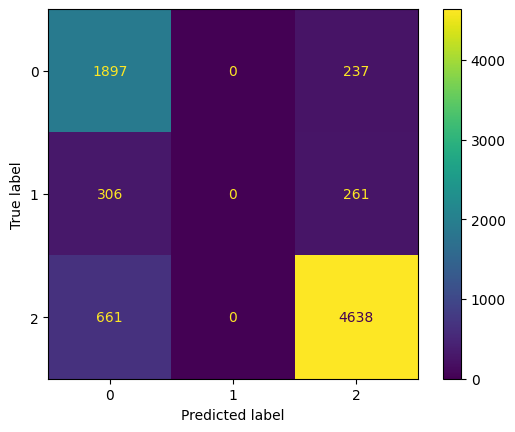

In [28]:
model = create_RNN(max_length)
model.summary()
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.002, restore_best_weights=True),
]
history = model.fit(train_ds.cache(), epochs=20, validation_data=val_ds.cache(), callbacks=callbacks)
print(f"Test dataset accuracy: {model.evaluate(test_ds)[1]}")
get_conf_matrix(model)

### 3.1 RNN with adjusted weights and default hyperparameters
- Weight for class 0: 1.25
- Weight for class 1: 4.70
- Weight for class 2: 0.50


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 100, 128)          1024000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                18560     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 1042659 (3.98 MB)
Trainable params: 1042659 (3.98 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
2025/2025 [==============================] - 52s 25ms/step - loss: 1.0756 - 

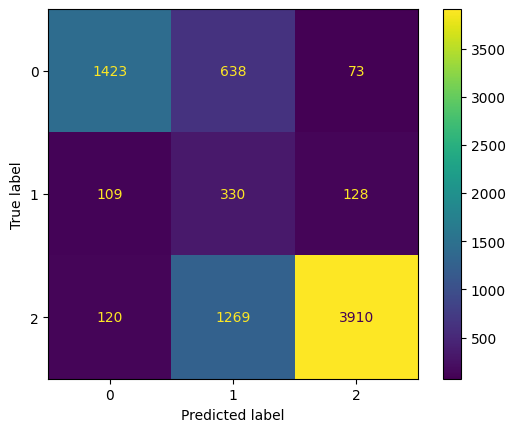

In [29]:
embedding_dim = 128
model = create_RNN(max_length, embedding_dim)
model.summary()
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.002, restore_best_weights=True),
]
history = model.fit(train_ds.cache(), epochs=20, validation_data=val_ds.cache(), callbacks=callbacks, class_weight=class_weight)
print(f"Test dataset accuracy: {model.evaluate(test_ds)[1]}")
get_conf_matrix(model)

### 3.2. RNN with hyperparameter tuning

In [27]:
def grid_search_RNN(epochs=20, patience=3):
    best_model = None
    best_accuracy = 0.0
    print(f"Need to train {len(param_grid_RNN['embedding_dim'])*len(param_grid_RNN['embedding_dim'])*len(param_grid_RNN['optimizer'])} RNNs.")
    count = 0
    for embedding_dim in param_grid_RNN['embedding_dim']:
        for lstm_unit in param_grid_RNN['lstm_units']:
            for optimizer in param_grid_RNN['optimizer']:
                model = create_RNN(max_length=max_length,
                                   embedding_dim=embedding_dim,
                                   lstm_units = lstm_unit,
                                   optimizer=optimizer)

                callbacks = [
                    keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
                ]

                history = model.fit(train_ds.cache(), epochs=epochs,
                                    validation_data=val_ds.cache(),
                                    callbacks=callbacks,
                                    class_weight=class_weight)

                val_acc = history.history['val_accuracy'][-1]  # Get last validation accuracy
                count+=1
                print(f"{count}/{len(param_grid_RNN['embedding_dim'])*len(param_grid_RNN['embedding_dim'])*len(param_grid_RNN['optimizer'])}")
                if val_acc > best_accuracy:
                    best_model = model
                    best_accuracy = val_acc
    return best_model, best_accuracy

# Example usage (assuming you have prepared your train_data and val_data)

# Example usage (assuming you have your training data)
param_grid_RNN = {
    'embedding_dim': [64, 128, 256],
    'lstm_units': [16, 32, 64],
    'optimizer': ['adam', 'sgd', 'adagrad'],
}

In [28]:
# %%capture
best_RNN, acc_RNN = grid_search_RNN()

Need to train 27 RNNs.
Epoch 1/20
2025/2025 [==============================] - 65s 30ms/step - loss: 0.7393 - accuracy: 0.7245 - val_loss: 0.5868 - val_accuracy: 0.7472
Epoch 2/20
2025/2025 [==============================] - 40s 20ms/step - loss: 0.5821 - accuracy: 0.7776 - val_loss: 0.6185 - val_accuracy: 0.7393
Epoch 3/20
2025/2025 [==============================] - 39s 19ms/step - loss: 0.4955 - accuracy: 0.8141 - val_loss: 0.5636 - val_accuracy: 0.7782
Epoch 4/20
2025/2025 [==============================] - 40s 20ms/step - loss: 0.4182 - accuracy: 0.8417 - val_loss: 0.5642 - val_accuracy: 0.7940
Epoch 5/20
2025/2025 [==============================] - 40s 20ms/step - loss: 0.3587 - accuracy: 0.8623 - val_loss: 0.7076 - val_accuracy: 0.7414
Epoch 6/20
2025/2025 [==============================] - 40s 20ms/step - loss: 0.3125 - accuracy: 0.8796 - val_loss: 0.6078 - val_accuracy: 0.8068
1/27
Epoch 1/20
2025/2025 [==============================] - 53s 25ms/step - loss: 1.0894 - accuracy:

2024-05-20 09:32:28.994708: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2025/2025 [==============================] - 59s 28ms/step - loss: 1.0951 - accuracy: 0.5667 - val_loss: 1.0775 - val_accuracy: 0.6435
Epoch 2/20
2025/2025 [==============================] - 41s 20ms/step - loss: 1.0873 - accuracy: 0.6470 - val_loss: 1.0590 - val_accuracy: 0.6332
Epoch 3/20
2025/2025 [==============================] - 39s 19ms/step - loss: 1.0719 - accuracy: 0.6260 - val_loss: 1.0368 - val_accuracy: 0.6256
Epoch 4/20
2025/2025 [==============================] - 39s 19ms/step - loss: 1.0593 - accuracy: 0.6214 - val_loss: 1.0310 - val_accuracy: 0.6207
Epoch 5/20
2025/2025 [==============================] - 39s 19ms/step - loss: 1.0530 - accuracy: 0.6181 - val_loss: 1.0269 - val_accuracy: 0.6168
Epoch 6/20
2025/2025 [==============================] - 39s 19ms/step - loss: 1.0483 - accuracy: 0.6176 - val_loss: 1.0221 - val_accuracy: 0.6168
Epoch 7/20
2025/2025 [==============================] - 40s 20ms/step - loss: 1.0437 - accuracy: 0.6192 - val_loss: 1.0163 - val_accura

Best val accuracy: 0.8140277862548828
250/250 [==============================] - 3s 10ms/step - loss: 0.6555 - accuracy: 0.8076
Test dataset accuracy: 0.8076249957084656
250/250 [==============================] - 2s 8ms/step


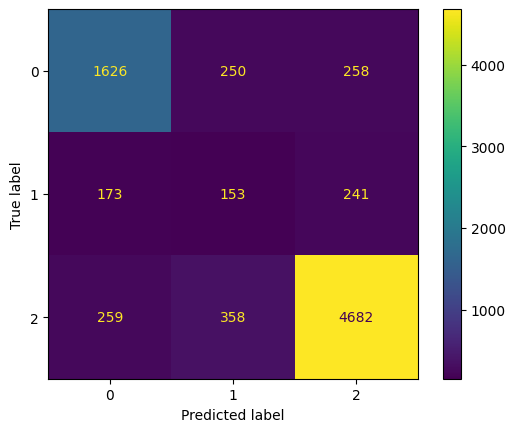

In [43]:
print(f"Best val accuracy: {acc_RNN}")
print(f"Test dataset accuracy: {best_RNN.evaluate(test_ds)[1]}")
get_conf_matrix(best_RNN)

In [45]:
def grid_search_CNN(epochs=30, patience=3):
    best_model = None
    best_accuracy = 0.0
    
    for embedding_dim in param_grid_CNN['embedding_dim']:
        for dropout_rate in param_grid_CNN['dropout_rate']:
            for optimizer in param_grid_CNN['optimizer']:
                for activation in param_grid_CNN['activation']:
                    model = create_CNN(max_length=max_length,
                                       embedding_dim=embedding_dim,
                                       dropout_rate=dropout_rate,
                                       optimizer=optimizer,
                                       activation=activation)

                    callbacks = [
                        keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
                    ]

                    history = model.fit(train_ds.cache(), epochs=epochs,
                                        validation_data=val_ds.cache(),
                                        callbacks=callbacks,
                                        class_weight=class_weight)

                    val_acc = history.history['val_accuracy'][-1]  # Get last validation accuracy
                    if val_acc > best_accuracy:
                        best_model = model
                        best_accuracy = val_acc
    return best_model, best_accuracy

# Example usage (assuming you have prepared your train_data and val_data)

# Example usage (assuming you have your training data)
param_grid_CNN = {
    'embedding_dim': [64, 128, 256],  
    'dropout_rate': [0.2, 0.3, 0.5],  
    'optimizer': ['adam', 'sgd'], 
    'activation': ['relu', 'leaky_relu']  
}

In [46]:
# %%capture
best_CNN, acc_CNN = grid_search_CNN()

Epoch 1/30
2025/2025 [==============================] - 39s 19ms/step - loss: 0.8500 - accuracy: 0.6691 - val_loss: 0.6882 - val_accuracy: 0.7058
Epoch 2/30
2025/2025 [==============================] - 15s 8ms/step - loss: 0.6950 - accuracy: 0.7423 - val_loss: 0.6283 - val_accuracy: 0.7186
Epoch 3/30
2025/2025 [==============================] - 16s 8ms/step - loss: 0.6112 - accuracy: 0.7758 - val_loss: 0.5662 - val_accuracy: 0.7632
Epoch 4/30
2025/2025 [==============================] - 16s 8ms/step - loss: 0.5427 - accuracy: 0.8080 - val_loss: 0.6829 - val_accuracy: 0.7239
Epoch 5/30
2025/2025 [==============================] - 16s 8ms/step - loss: 0.4834 - accuracy: 0.8342 - val_loss: 0.7022 - val_accuracy: 0.7188
Epoch 6/30
2025/2025 [==============================] - 16s 8ms/step - loss: 0.4336 - accuracy: 0.8544 - val_loss: 0.6836 - val_accuracy: 0.7411
Epoch 1/30
2025/2025 [==============================] - 38s 18ms/step - loss: 0.8311 - accuracy: 0.6820 - val_loss: 0.6274 - val_

In [41]:
model = create_CNN(max_length)
model.summary()

# Train the model (replace with your training and validation data)
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.002, restore_best_weights=True),
]

history = model.fit(train_ds.cache(), epochs=3, validation_data=val_ds.cache(), callbacks=callbacks)
model.evaluate(test_ds)
print(f"Test dataset accuracy: {model.evaluate(test_ds)[1]}")
get_conf_matrix(model)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_7 (Embedding)     (None, 100, 128)          1024000   
                                                                 
 conv1d_12 (Conv1D)          (None, 96, 128)           82048     
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 48, 128)           0         
 ng1D)                                                           
                                                                 
 conv1d_13 (Conv1D)          (None, 48, 64)            32832     
                                                                 
 max_pooling1d_13 (MaxPooli  (None, 24, 64)            0         
 ng1D)                                                     

KeyboardInterrupt: 